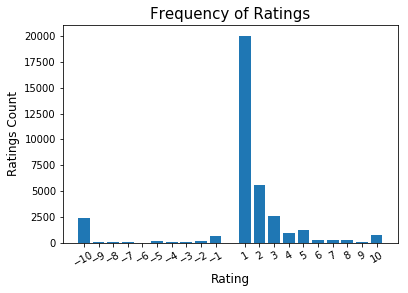

In [114]:
%matplotlib inline 
import pandas as pd
import numpy as np
import networkx as nx
import math
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

headers=["Source","Target","Rating","Timestamp"]

df=pd.read_csv("bitotc.csv",names=headers)

# Plot for frequency of ratings
data1 = df['Rating'].value_counts()
data1 = pd.DataFrame({'Rating':data1.index, 'Count':data1.values})
plt.bar(data1['Rating'], data1['Count'])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Ratings Count', fontsize=12)
plt.xticks(data1['Rating'], fontsize=10, rotation=30)
plt.title('Frequency of Ratings', fontsize = 15)


df=df.drop("Timestamp",1)
df["Rating"]=df["Rating"]/10

# Dictionaries for holding fairness and goodness values
fairness = {}
goodness = {}

G = nx.DiGraph()

for index, row in df.iterrows():
    G.add_edge(row[0], row[1], weight = float(row[2]))

nodes = G.nodes()

# Initialize fairness and goodness values to 1
for node in nodes:
    fairness[node] = 1
    goodness[node] = 1

# Function for calculating Goodness Value
def goodness_value(G):
    for node in nodes:
        inedges = G.in_edges(node, data='weight')
        g = 0
        for edge in inedges:
            g += fairness[edge[0]]*edge[2]
        try:
            goodness[node] = g/len(inedges)
        except:
            pass
    return goodness

# Function for calculating Fairness Value
def fairness_value(G):
    for node in nodes:
        outedges = G.out_edges(node, data='weight')
        f = 0
        for edge in outedges:
            weight_diff = abs(edge[2] - goodness[edge[1]])
            f += (weight_diff/2.0)
        try:
            fairness[node] = 1.0-f/len(outedges)
        except:
            pass
    return fairness

goodness_value=goodness_value(G)
fairness_value=fairness_value(G)

In [72]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 250
fig_size[1] = 250
plt.rcParams["figure.figsize"] = fig_size

In [ ]:
Gr = nx.from_pandas_edgelist(df[:35000], 'Source', 'Target', create_using=nx.DiGraph())
nx.draw(Gr, with_labels=True, node_size=2000, node_shape="8", alpha=0.5, linewidths=4, font_size=8, font_color="black", font_weight="bold", width=2, edge_color="grey")
plt.show()

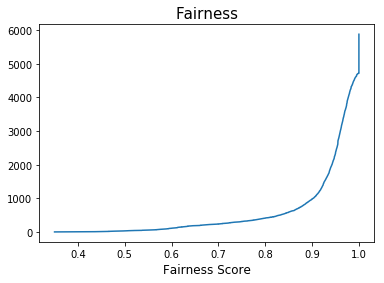

In [9]:
# Plot the graph between fairness value
fairness_list = sorted(fairness_value.values())
x=range(0,len(fairness_list))
plt.plot(fairness_list, x)
plt.xlabel('Fairness Score', fontsize = 12)
plt.title('Fairness', fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()

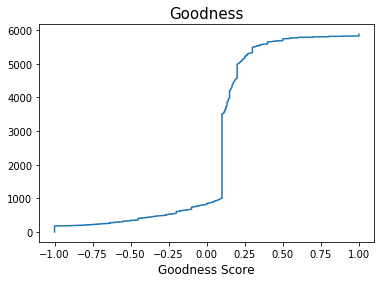

In [10]:
# Plot for goodness score
goodness_list = sorted(goodness_value.values())
x=range(0,len(goodness_list))
plt.xlabel('Goodness Score', fontsize = 12)
plt.title('Goodness', fontsize = 15)
plt.plot(goodness_list,x)
plt.show()

In [2]:
# Calculate centrality measures
Ga = nx.from_pandas_edgelist(df,"Source","Target")
degree=nx.degree_centrality(Ga)
betweenness=nx.betweenness_centrality(Ga)
eigenvector=nx.eigenvector_centrality(Ga)
clustering=nx.clustering(Ga)

In [70]:
# Function to check whether the node is trustworthy or not
def indivisualScore(node):
    
    try:
        
        goodness=goodness_value[node]
        print("Goodness Value of",node,"is:",goodness)
        fairness=fairness_value[node]
        print("Fairness Value of",node,"is:",fairness)
        if(goodness > np.median(np.array(goodness_list))) & (fairness > np.median(np.array(fairness_list))):
            print("The node",node,"is trustworthy")
        else:
            print("User is not trustworthy")
        print("The Centrality Measures of node",node,"are as follows:")
        print("Degree Centrality:",degree[node],",Betweenness Centarlity:",betweenness[node],",Eigenvector Centrality:",eigenvector[node],",Clustering:",clustering[node])
        
    except:
        
        print("Node not found")

In [71]:
# Verifying the function for node 9
indivisualScore(16)

Goodness Value of 16 is: 0.8
Fairness Value of 16 is: 1
The node 16 is trustworthy
The Centrality Measures of node 16 are as follows:
Degree Centrality: 0.00017006802721088434 ,Betweenness Centarlity: 0.0 ,Eigenvector Centrality: 0.0020727481871616613 ,Clustering: 0


In [12]:
# Dataframe with fairness, goodness and centrality measures values
centrality_df=pd.DataFrame(index=degree.keys())
centrality_df["degree"]=degree.values()
centrality_df["betweeness"]=betweenness.values()
centrality_df["clustering"]=clustering.values()
centrality_df["eigenvector"]=clustering.values()
centrality_df["goodness_score"]=goodness_value.values()
centrality_df["fairness_score"]=fairness_value.values()
centrality_df.sort_values(by = ['fairness_score', 'goodness_score'],ascending=False)
centrality_df.index.name = 'Node'
centrality_df.head(10)

,degree,betweeness,clustering,eigenvector,goodness_score,fairness_score
Node,,,,,,
6.0,0.009354,0.004392,0.138047,0.138047,0.138636,0.896301
2.0,0.009014,0.002361,0.112482,0.112482,0.300000,0.896899
5.0,0.000510,0.000000,1.000000,1.000000,0.233333,0.933325
1.0,0.044898,0.052810,0.050006,0.050006,0.354425,0.922725
15.0,0.002891,0.000696,0.080882,0.080882,0.153846,0.957072
4.0,0.011565,0.007283,0.100527,0.100527,0.311111,0.894550
3.0,0.003571,0.000644,0.161905,0.161905,-0.028571,1.000000
13.0,0.036565,0.032108,0.043599,0.043599,0.178534,0.945305
16.0,0.000170,0.000000,0.000000,0.000000,0.800000,1.000000


[Text(0,0,'Goodness Score'), Text(0,0,'Fairness Score')]

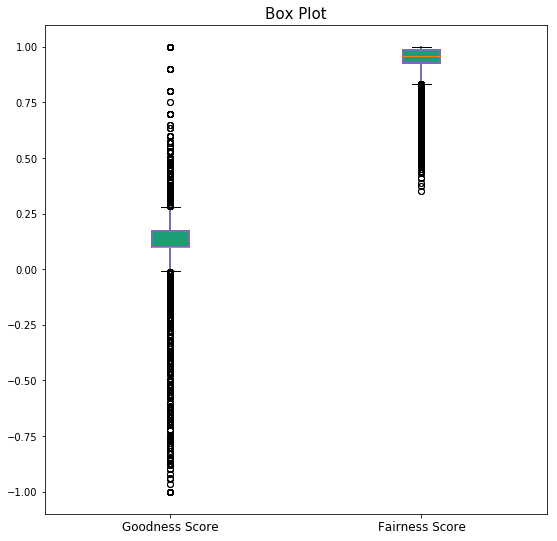

In [54]:
data = [centrality_df['goodness_score'], centrality_df['fairness_score']]
fig = plt.figure(1, figsize=(9, 9))
ax = fig.add_subplot(111)
ax.boxplot(data)
plt.title('Box Plot', fontsize = 15)
#plt.yticks(np.arange(min(centrality_df['goodness_score']), max(centrality_df['goodness_score'])+0.2, 0.1))
bp = ax.boxplot(data, patch_artist=True)
for box in bp['boxes']:
    box.set( color='#7570b3', linewidth=2)
    box.set( facecolor = '#1b9e77' )
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
ax.set_xticklabels(['Goodness Score', 'Fairness Score'], fontsize = 12)

Most active users but should not be trusted. Node 35 has low eigen vector centrality even though it has highest degree and betweenness. This shows that node 35 is not important node in the network

In [105]:
centrality_df[(centrality_df['fairness_score'] > centrality_df['fairness_score'].median()) & (centrality_df['goodness_score'] > centrality_df['goodness_score'].median())].head(10)

,degree,betweeness,clustering,eigenvector,goodness_score,fairness_score
Node,,,,,,
16.0,0.000170,0.000000,0.000000,0.000000,0.800000,1.000000
20.0,0.001701,0.000074,0.377778,0.377778,0.200000,1.000000
8.0,0.000510,0.000000,1.000000,1.000000,0.566667,0.972788
25.0,0.019218,0.010723,0.064791,0.064791,0.261062,1.000000
29.0,0.007313,0.003169,0.078627,0.078627,0.205714,0.970161
35.0,0.135204,0.193143,0.003419,0.003419,0.189907,0.982273
36.0,0.006293,0.004756,0.054054,0.054054,0.187879,0.966832
56.0,0.001190,0.000138,0.571429,0.571429,0.183333,0.963704
70.0,0.001020,0.000054,0.266667,0.266667,0.183333,0.962020


In [104]:
# Most Trusted Users
centrality_df[(centrality_df['fairness_score'] > centrality_df['fairness_score'].median()) & (centrality_df['goodness_score'] > centrality_df['goodness_score'].median()) & (centrality_df['eigenvector'] > 0.607)].head(10)

,degree,betweeness,clustering,eigenvector,goodness_score,fairness_score
Node,,,,,,
8.0,0.00051,0.000000,1.000000,1.000000,0.566667,0.972788
89.0,0.00034,0.000000,1.000000,1.000000,0.150000,0.962093
105.0,0.00034,0.000000,1.000000,1.000000,0.350000,0.966316
157.0,0.00034,0.000000,1.000000,1.000000,0.150000,0.975345
263.0,0.00034,0.000000,1.000000,1.000000,0.150000,0.974359
264.0,0.00034,0.000000,1.000000,1.000000,0.450000,1.000000
358.0,0.00034,0.000000,1.000000,1.000000,0.300000,0.975195
551.0,0.00034,0.000000,1.000000,1.000000,0.150000,1.000000
620.0,0.00051,0.000006,0.666667,0.666667,0.100000,0.972868


In [166]:
# Adding new column by multiplying fairness and goodness values
Source_GF = list(centrality_df.loc[df['Source']/1.0]['goodness_score'] * centrality_df.loc[df['Source']/1.0]['fairness_score'])
df['Source_GF'] = Source_GF
# Target_GF = list(centrality_df.loc[df['Target']/1.0]['goodness_score'] * centrality_df.loc[df['Target']/1.0]['fairness_score'])
# df['Target_GF'] = Target_GF
# df = df.drop(['Target_GF'], axis = 1)

In [167]:
labels = df['Rating']
df = df.drop(['Rating'], axis = 1)

In [168]:
df.head()

,Source,Target,Source_GF
0,6,2,0.124260
1,6,5,0.124260
2,1,15,0.327037
3,4,3,0.278304
4,13,16,0.168769


In [180]:
# Split the data into parts with 90% of the data as training data and 10% as the testing data
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size = 0.1, random_state = 1)

In [185]:
# Initialize Regression Models
linear_reg = LinearRegression()
ridge_reg = Ridge()
rf = RandomForestRegressor(random_state=1, n_estimators=100)

In [109]:
linear_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [110]:
ridge_reg.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [186]:
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [112]:
linear_pred = np.around(linear_reg.predict(x_test))

In [113]:
ridge_pred = np.around(ridge_reg.predict(x_test))

In [187]:
rf_pred = np.around(rf.predict(x_test))

In [188]:
rf.score(x_test, y_test)

0.35338011135949343

In [115]:
y_test_val = y_test.values

In [116]:
# RMSE for Linear Regression
linear_mse = (mean_squared_error(linear_pred, y_test)) ** 0.5
linear_mse

0.36623655399638366

In [117]:
# RMSE for Ridge Regression
ridge_mse = (mean_squared_error(ridge_pred, y_test)) ** 0.5
ridge_mse

0.36623655399638366

In [189]:
# RMSE for Random Forest
rf_mse = (mean_squared_error(rf_pred, y_test)) ** 0.5
rf_mse

0.32797471812677437

In [138]:
data1 = df['Rating'].value_counts()
data1 = pd.DataFrame({'Rating':data1.index, 'Count':data1.values})

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
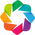

In [79]:
import holoviews as hv
hv.extension('bokeh')

%opts Graph [width=400 height=400]

In [102]:
%%output size=250
def get_graph(iteration):
    np.random.seed(10)
    return hv.Graph.from_networkx(Gr, nx.spring_layout, iterations=iteration)

hv.HoloMap({i: get_graph(i) for i in range(5, 30, 5)},
           kdims='Iterations').redim.range(x=(-0.12, 0.12), y=(-0.12, 0.12))

:HoloMap   [Iterations]
   :Graph   [start,end]